In [1]:
from pyspark.ml.classification import LinearSVC
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler   
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix



In [2]:
# read training and test data from csv files
TRAINING_PATH = "./train_selected.csv"
TESTING_PATH = "./test_selected.csv"

In [3]:

spark = SparkSession.builder.appName("SVM").getOrCreate()
sc = spark.sparkContext

In [13]:
all_training_rdd = spark.read.csv(TRAINING_PATH, header=True, inferSchema=True)
testing_rdd = spark.read.csv(TESTING_PATH, header=True, inferSchema=True)

# split training into training and validation
(training_rdd, validation_rdd) = all_training_rdd.randomSplit([0.8, 0.2]) # print dataset length
print("Training data length: ", training_rdd.count())
print("Testing data length: ", testing_rdd.count())

# print the count of label values in training data
training_rdd.groupBy("label").count().show()
testing_rdd.groupBy("label").count().show()

Training data length:  113764
Testing data length:  58329
+-----+-----+
|label|count|
+-----+-----+
|    1|65294|
|    0|48470|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    1|33370|
|    0|24959|
+-----+-----+



In [5]:
training_rdd.printSchema()

root
 |-- URLSimilarityIndex: double (nullable = true)
 |-- HasSocialNet: integer (nullable = true)
 |-- NoOfJS: integer (nullable = true)
 |-- NoOfImage: integer (nullable = true)
 |-- HasDescription: integer (nullable = true)
 |-- IsHTTPS: integer (nullable = true)
 |-- label: integer (nullable = true)



In [17]:
def eval_model(predictions, eval_label="Test"):
    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"{eval_label} Accuracy = {accuracy:.20f}")

    # show presicion, recall and f1 score
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    precision = evaluator.evaluate(predictions)
    print(f"{eval_label} Precision = {precision:.20f}")

    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    recall = evaluator.evaluate(predictions)
    print(f"{eval_label} Recall = {recall:.20f}")

    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions)
    print(f"{eval_label} F1 Score = {f1:.20f}")
     # Plot confusion matrix using sklearn
    y_true = predictions.select("label").toPandas()
    y_pred = predictions.select("prediction").toPandas()
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=True, yticklabels=True)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    return accuracy, precision, recall, f1

Test LinearSVC Accuracy = 0.98782766719813475120
Test LinearSVC Precision = 0.98808125746484021246
Test LinearSVC Recall = 0.98782766719813475120
Test LinearSVC F1 Score = 0.98780391756232766021


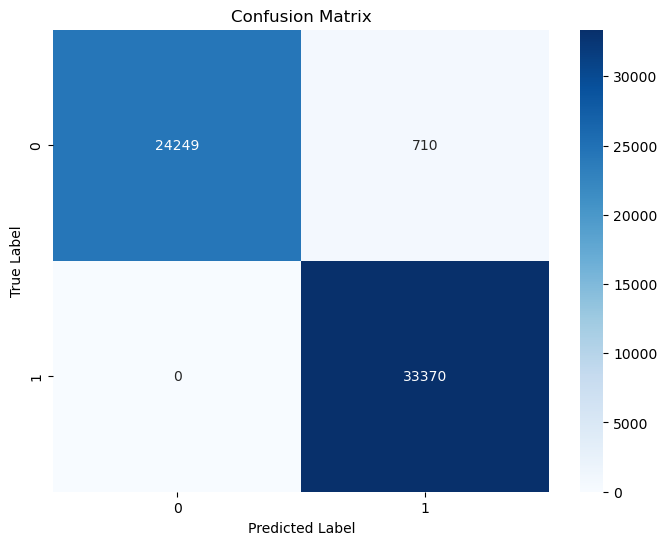

Validation LinearSVC Accuracy = 0.98873520604591469407
Validation LinearSVC Precision = 0.98895284329765664744
Validation LinearSVC Recall = 0.98873520604591469407
Validation LinearSVC F1 Score = 0.98871507279793557910


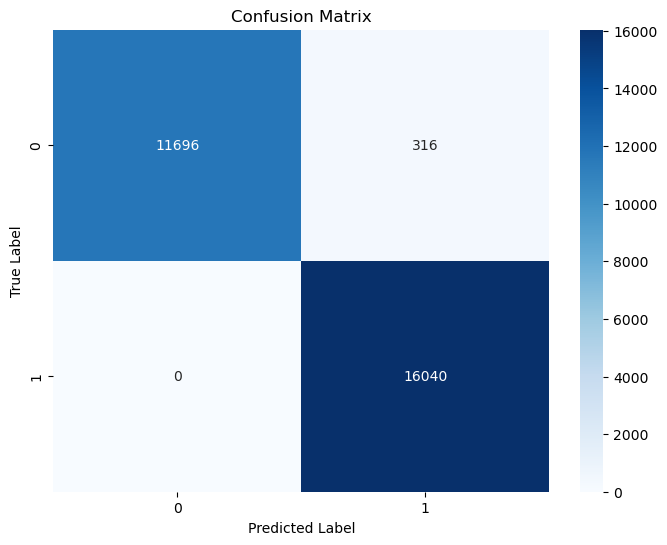

(0.9887352060459147,
 0.9889528432976566,
 0.9887352060459147,
 0.9887150727979356)

In [18]:
#
# Specify the feature columns, excluding the label column
feature_columns = [col for col in training_rdd.columns if col in [ "URLLength", "URLSimilarityIndex"]]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Assemble features for both train and test datasets
train_df = assembler.transform(training_rdd).select("features", "label")
test_df = assembler.transform(testing_rdd).select("features", "label")
validation_df = assembler.transform(validation_rdd).select("features", "label")
# Initialize the LinearSVC model
svm = LinearSVC(labelCol="label", featuresCol="features", maxIter=100)

# Train the LinearSVC model
svm_model = svm.fit(train_df)

# Make predictions on the test set
predictions = svm_model.transform(test_df)
eval_model(predictions, "Test LinearSVC")

val_predictions = svm_model.transform(validation_df)
eval_model(val_predictions, "Validation LinearSVC")

In [8]:
# training accuracy
training_pred = svm_model.transform(train_df)
training_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(training_pred)
print("Training accuracy: ", training_accuracy)


Training accuracy:  0.9885837987251086
